# Ziper demand forecast
- This notebook has the goal of analyzing and predicting gloves sales
- We first do an EDA and feature selection
- Then we train the model with the selected features
- The model is evaluated
- We procede with hyperparameters tuning
- Then evaluate the model again
- Predict sales for next 3 months
- Calculate the number of zipers needed

## Importing libraries

In [41]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import timedelta
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import itertools
from datetime import timedelta

## Bigquery connection using Service Account key file

In [42]:
# Set up BigQuery client with service account
service_account_path = '../dbt/keys/prediction-model-python.json'
credentials = service_account.Credentials.from_service_account_file(service_account_path)
project_id = 'robotic-parsec-433018-g3'
client = bigquery.Client(credentials=credentials, project=project_id)

## Loading table with sales by week per product

In [43]:
def load_table(table_name):
    query = f"SELECT * FROM `{project_id}.dev_adventure_works.{table_name}`"
    return client.query(query).to_dataframe()

# Load all agg tables
agg_sales_by_product = load_table('agg_sales_by_product_ml')
agg_sales_by_product

,product_id,product_name,product_category_name,product_subcategory_name,product_line,class,style,make_flag,safety_stock_level,reorder_point,...,unit_price_discount,avg_unit_freight,online_order_flag,ship_method_name,sales_person_id,sales_reason_names,sales_reason_types,discount_pct,is_first_purchase,has_discount
0,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,307.743200,False,CARGO TRANSPORT 5,2,None,None,0E-9,True,0
1,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,233.469100,False,CARGO TRANSPORT 5,5,None,None,0E-9,True,0
2,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,85.440575,False,CARGO TRANSPORT 5,8,None,None,0E-9,True,0
3,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,429.982100,False,CARGO TRANSPORT 5,10,None,None,0E-9,True,0
4,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,291.589600,False,CARGO TRANSPORT 5,8,None,None,0E-9,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110830,999,"Road-750 Black, 52",Bikes,Road Bikes,R,L,U,True,100,75,...,0.0,13.499800,True,XRQ - TRUCK GROUND,<NA>,None,None,0E-9,True,0
110831,999,"Road-750 Black, 52",Bikes,Road Bikes,R,L,U,True,100,75,...,0.0,15.087300,True,XRQ - TRUCK GROUND,<NA>,None,None,0E-9,True,0
110832,999,"Road-750 Black, 52",Bikes,Road Bikes,R,L,U,True,100,75,...,0.0,14.374500,True,XRQ - TRUCK GROUND,<NA>,None,None,0E-9,True,0
110833,999,"Road-750 Black, 52",Bikes,Road Bikes,R,L,U,True,100,75,...,0.0,13.499800,True,XRQ - TRUCK GROUND,<NA>,None,None,0E-9,True,0


## Selecting gloves sales only

In [44]:
# Filter for products where the product_subcategory_name is 'Gloves'
gloves_df = agg_sales_by_product[agg_sales_by_product['product_subcategory_name'].str.contains('Gloves', case=False, na=False)]

# Display the filtered dataframe
gloves_df.head()

,product_id,product_name,product_category_name,product_subcategory_name,product_line,class,style,make_flag,safety_stock_level,reorder_point,...,unit_price_discount,avg_unit_freight,online_order_flag,ship_method_name,sales_person_id,sales_reason_names,sales_reason_types,discount_pct,is_first_purchase,has_discount
51155,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,0.0,430.064525,False,CARGO TRANSPORT 5,4,None,None,0E-9,True,0
51156,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,0.0,270.367860,False,CARGO TRANSPORT 5,3,None,None,0E-9,True,0
51157,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,0.0,1261.263369,False,CARGO TRANSPORT 5,16,None,None,0E-9,True,0
51158,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,0.0,780.763100,False,CARGO TRANSPORT 5,16,None,None,0E-9,True,0
51159,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,0.0,655.513150,False,CARGO TRANSPORT 5,17,None,None,0E-9,True,0


## Fixing sales reason colunmns and replacing NaN with 0
- Sales reasons are concatenated by commas and could be repeated. Fixing this here creating new columns for each sales reason and type

In [45]:
# First, split the concatenated values into lists
gloves_df['sales_reason_names'] = gloves_df['sales_reason_names'].str.split(',')
gloves_df['sales_reason_types'] = gloves_df['sales_reason_types'].str.split(',')

# Strip leading/trailing spaces and fill NaN with empty list
gloves_df['sales_reason_names'] = gloves_df['sales_reason_names'].apply(lambda x: [s.strip() for s in x] if isinstance(x, list) else [])
gloves_df['sales_reason_types'] = gloves_df['sales_reason_types'].apply(lambda x: [s.strip() for s in x] if isinstance(x, list) else [])

# Ensure uniqueness within each list to avoid reindexing issues
gloves_df['sales_reason_names'] = gloves_df['sales_reason_names'].apply(lambda x: list(set(x)) if isinstance(x, list) else [])
gloves_df['sales_reason_types'] = gloves_df['sales_reason_types'].apply(lambda x: list(set(x)) if isinstance(x, list) else [])

# Create dummy variables (one-hot encoding) for sales_reason_names
sales_reason_dummies = gloves_df['sales_reason_names'].apply(lambda x: pd.Series(1, index=x)).fillna(0)

# Create dummy variables (one-hot encoding) for sales_reason_types
sales_type_dummies = gloves_df['sales_reason_types'].apply(lambda x: pd.Series(1, index=x)).fillna(0)

# Combine the dummy columns with the original dataframe
gloves_df_with_dummies = pd.concat([gloves_df, sales_reason_dummies.add_prefix('reason_'), sales_type_dummies.add_prefix('type_')], axis=1)

# Drop the original sales_reason columns if not needed anymore
gloves_df_with_dummies.drop(['sales_reason_names', 'sales_reason_types'], axis=1, inplace=True)

gloves_df = gloves_df_with_dummies

gloves_df

,product_id,product_name,product_category_name,product_subcategory_name,product_line,class,style,make_flag,safety_stock_level,reorder_point,...,ship_method_name,sales_person_id,discount_pct,is_first_purchase,has_discount,reason_Price,reason_Other,reason_On Promotion,type_Other,type_Promotion
51155,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,CARGO TRANSPORT 5,4,0E-9,True,0,0.0,0.0,0.0,0.0,0.0
51156,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,CARGO TRANSPORT 5,3,0E-9,True,0,0.0,0.0,0.0,0.0,0.0
51157,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,CARGO TRANSPORT 5,16,0E-9,True,0,0.0,0.0,0.0,0.0,0.0
51158,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,CARGO TRANSPORT 5,16,0E-9,True,0,0.0,0.0,0.0,0.0,0.0
51159,858,"Half-Finger Gloves, S",Clothing,Gloves,S,None,U,False,4,3,...,CARGO TRANSPORT 5,17,0E-9,True,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54291,863,"Full-Finger Gloves, L",Clothing,Gloves,M,None,U,False,4,3,...,CARGO TRANSPORT 5,10,0E-9,False,0,0.0,0.0,0.0,0.0,0.0
54292,863,"Full-Finger Gloves, L",Clothing,Gloves,M,None,U,False,4,3,...,CARGO TRANSPORT 5,5,0E-9,False,0,0.0,0.0,0.0,0.0,0.0
54293,863,"Full-Finger Gloves, L",Clothing,Gloves,M,None,U,False,4,3,...,CARGO TRANSPORT 5,15,0E-9,True,0,0.0,0.0,0.0,0.0,0.0
54294,863,"Full-Finger Gloves, L",Clothing,Gloves,M,None,U,False,4,3,...,CARGO TRANSPORT 5,15,0E-9,False,0,0.0,0.0,0.0,0.0,0.0


In [46]:
gloves_df.fillna(0, inplace=True)

## Feature selection
- We analyze the correlation between the target variable total_products_sold and both numerical and categorical variables to select those with high correlation, which will likely be important for model performance.

### Converting date fields into numerical fields

In [47]:
# Convert week_start_date to year, month, and day
gloves_df['week_start_year'] = gloves_df['week_start_date'].dt.year
gloves_df['week_start_month'] = gloves_df['week_start_date'].dt.month
gloves_df['week_start_day'] = gloves_df['week_start_date'].dt.day

# Drop the original Datetime columns
gloves_df = gloves_df.drop(columns=['sell_start_date', 'week_start_date', 'sell_end_date'])

# Display the updated dataframe to confirm the conversion
gloves_df.head()

,product_id,product_name,product_category_name,product_subcategory_name,product_line,class,style,make_flag,safety_stock_level,reorder_point,...,is_first_purchase,has_discount,reason_Price,reason_Other,reason_On Promotion,type_Other,type_Promotion,week_start_year,week_start_month,week_start_day
51155,858,"Half-Finger Gloves, S",Clothing,Gloves,S,0,U,False,4,3,...,True,0,0.0,0.0,0.0,0.0,0.0,2012,5,28
51156,858,"Half-Finger Gloves, S",Clothing,Gloves,S,0,U,False,4,3,...,True,0,0.0,0.0,0.0,0.0,0.0,2012,5,28
51157,858,"Half-Finger Gloves, S",Clothing,Gloves,S,0,U,False,4,3,...,True,0,0.0,0.0,0.0,0.0,0.0,2012,5,28
51158,858,"Half-Finger Gloves, S",Clothing,Gloves,S,0,U,False,4,3,...,True,0,0.0,0.0,0.0,0.0,0.0,2012,5,28
51159,858,"Half-Finger Gloves, S",Clothing,Gloves,S,0,U,False,4,3,...,True,0,0.0,0.0,0.0,0.0,0.0,2012,5,28


### Removing columns that only have one value
- These columns will not contribute to the prediction algorithm, since it does not change

In [48]:
# Removing columns that only have one unique value
gloves_df = gloves_df.drop(['product_subcategory_name', 'product_category_name', 'class', 'style', 'make_flag', 'safety_stock_level', 'reorder_point', 'days_to_manufacture', 'finished_goods_flag', 'store_name', 'discount_pct'], axis=1)
gloves_df[['product_name', 'product_size']] = (gloves_df['product_name']).str.split(', ', expand=True)
gloves_df.head()

,product_id,product_name,product_line,sales_territory_name,city_district_name,state_province_name,store_id,total_products_sold,unit_price,unit_price_discount,...,has_discount,reason_Price,reason_Other,reason_On Promotion,type_Other,type_Promotion,week_start_year,week_start_month,week_start_day,product_size
51155,858,Half-Finger Gloves,S,Southwest,Unknown,Unknown,0,4,14.1289,0.0,...,0,0.0,0.0,0.0,0.0,0.0,2012,5,28,S
51156,858,Half-Finger Gloves,S,Southwest,Unknown,Unknown,0,5,14.1289,0.0,...,0,0.0,0.0,0.0,0.0,0.0,2012,5,28,S
51157,858,Half-Finger Gloves,S,Canada,Unknown,Unknown,0,10,14.1289,0.0,...,0,0.0,0.0,0.0,0.0,0.0,2012,5,28,S
51158,858,Half-Finger Gloves,S,Canada,Unknown,Unknown,592,6,14.1289,0.0,...,0,0.0,0.0,0.0,0.0,0.0,2012,5,28,S
51159,858,Half-Finger Gloves,S,France,Unknown,Unknown,0,2,14.1289,0.0,...,0,0.0,0.0,0.0,0.0,0.0,2012,5,28,S


### Reagregating after columns deletions

In [49]:
gloves_df = gloves_df.groupby(list(gloves_df.columns.drop('total_products_sold'))).agg({'total_products_sold': 'sum'}).reset_index()
gloves_df

,product_id,product_name,product_line,sales_territory_name,city_district_name,state_province_name,store_id,unit_price,unit_price_discount,avg_unit_freight,...,reason_Price,reason_Other,reason_On Promotion,type_Other,type_Promotion,week_start_year,week_start_month,week_start_day,product_size,total_products_sold
0,858,Half-Finger Gloves,S,Australia,Bendigo,Victoria,0,24.490,0.0,2.124000,...,1.0,0.0,0.0,1.0,0.0,2013,9,23,S,1
1,858,Half-Finger Gloves,S,Australia,Bendigo,Victoria,0,24.490,0.0,2.836800,...,1.0,0.0,0.0,1.0,0.0,2014,1,6,S,1
2,858,Half-Finger Gloves,S,Australia,Bendigo,Victoria,0,24.490,0.0,14.986800,...,1.0,0.0,0.0,1.0,0.0,2014,3,3,S,1
3,858,Half-Finger Gloves,S,Australia,Bendigo,Victoria,0,24.490,0.0,31.858300,...,1.0,0.0,1.0,1.0,1.0,2014,3,17,S,1
4,858,Half-Finger Gloves,S,Australia,Bendigo,Victoria,0,24.490,0.0,59.861500,...,1.0,0.0,0.0,1.0,0.0,2013,9,2,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,863,Full-Finger Gloves,M,United Kingdom,Unknown,Unknown,0,22.794,0.0,131.938374,...,0.0,0.0,0.0,0.0,0.0,2012,7,30,L,10
3136,863,Full-Finger Gloves,M,United Kingdom,Unknown,Unknown,0,22.794,0.0,152.512325,...,0.0,0.0,0.0,0.0,0.0,2012,12,31,L,6
3137,863,Full-Finger Gloves,M,United Kingdom,Unknown,Unknown,0,22.794,0.0,191.548028,...,0.0,0.0,0.0,0.0,0.0,2012,10,29,L,15
3138,863,Full-Finger Gloves,M,United Kingdom,Unknown,Unknown,0,22.794,0.0,199.543463,...,0.0,0.0,0.0,0.0,0.0,2012,6,25,L,8


### Calculating correlation between numerical variables

- The heatmap shows the Pearson correlation between numerical variables and `total_products_sold`.
- The variables with the highest positive correlation with `total_products_sold` are:
  - `unit_price_discount` (0.71)
  - `week_start_day` (0.38)

- `avg_unit_freight` shows a very weak positive correlation (0.02) with `total_products_sold`.

- Variables that show a negative correlation with `total_products_sold`:
  - `unit_price` (-0.33)
  - `week_start_year` (-0.38)
  - `week_start_month` (-0.01)

- No strong correlation exists between `total_products_sold` and variables like `avg_unit_freight` or `week_start_month`, indicating these features may have little influence on `total_products_sold` in this dataset.


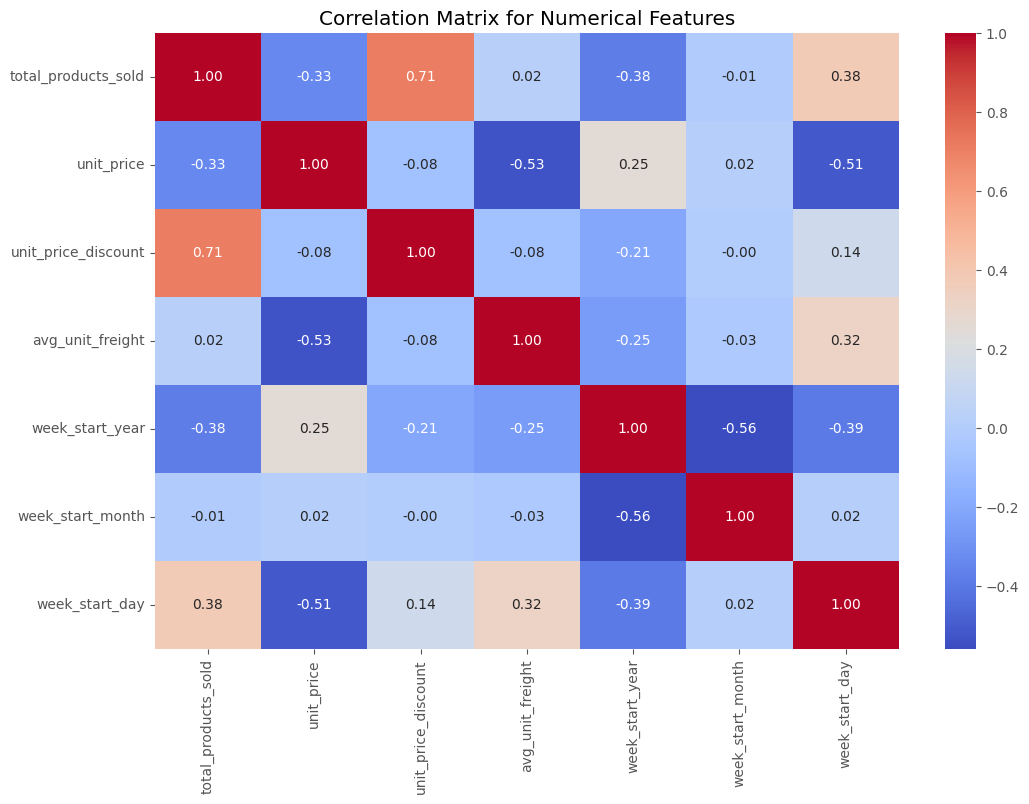

total_products_sold    1.000000
unit_price_discount    0.712655
week_start_day         0.376823
avg_unit_freight       0.020633
week_start_month      -0.006542
unit_price            -0.334517
week_start_year       -0.381222
Name: total_products_sold, dtype: float64


In [50]:
# Updated list of numerical columns (including the new variables)
numerical_cols = ['total_products_sold', 'unit_price', 
                  'unit_price_discount', 'avg_unit_freight',
                  'week_start_year', 'week_start_month', 'week_start_day',
                  ]

# Calculate the correlation matrix for numerical features
corr_matrix = gloves_df[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

# Display the most correlated features with total_products_sold
corr_target = corr_matrix['total_products_sold'].sort_values(ascending=False)
print(corr_target)


### Calculating correlation between categorical variables and `total_products_sold`

- We used Cramér's V to measure the association between categorical variables and `total_products_sold`.
- The variables with the highest correlation are:
  - `ship_method_name`, `type_Other`, and `reason_Price` all have a strong correlation (0.90), indicating that shipping method, price-related reasons, and other types of purchases are strong predictors of product sales.
  - `is_first_purchase` also has a notable correlation (0.65), suggesting that whether a purchase is a customer's first may impact sales.

- Other categorical variables with moderate correlation include:
  - `product_line` (0.53)
  - `product_id` and `product_name` (both 0.32)
  - `sales_person_id` (0.26)

- Some features like `reason_On Promotion`, `type_Promotion`, and `reason_Other` show weaker correlations, but may still have some impact.

- A few features, such as `product_category_name`, `product_subcategory_name`, `class`, `style`, `size_unit_measure_name`, `weight_unit_measure_name`, `make_flag`, and `finished_goods_flag`, appear to have no significant correlation (NaN), suggesting that these variables do not influence `total_products_sold` in this dataset.


In [51]:
# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

# Updated list of categorical columns
categorical_cols = ['product_id', 'product_name', 'product_line', 'sales_territory_name',
                    'city_district_name', 'state_province_name', 'store_id',
                    'online_order_flag', 'ship_method_name',
                    'sales_person_id', 'is_first_purchase', 'has_discount', 'reason_Price',
                    'reason_Other', 'reason_On Promotion', 'type_Other', 'type_Promotion',
                    'product_size']

# Encode categorical columns using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    gloves_df[col] = le.fit_transform(gloves_df[col].astype(str))

# Store Cramér's V values for each categorical feature against total_products_sold
cramers_v_scores = {}

for col in categorical_cols:
    confusion_matrix = pd.crosstab(gloves_df[col], gloves_df['total_products_sold'])
    cramers_v_score = cramers_v(confusion_matrix.values)
    cramers_v_scores[col] = cramers_v_score

# Sort the Cramér's V values and print them
cramers_v_sorted = pd.Series(cramers_v_scores).sort_values(ascending=False)
print(cramers_v_sorted)


type_Other              0.899867
reason_Price            0.899867
online_order_flag       0.899867
ship_method_name        0.899867
has_discount            0.651255
is_first_purchase       0.644396
product_name            0.529859
product_line            0.529859
product_id              0.312660
sales_person_id         0.254906
reason_On Promotion     0.227149
type_Promotion          0.227149
reason_Other            0.202351
product_size            0.193431
sales_territory_name    0.183198
store_id                0.173717
city_district_name      0.148291
state_province_name     0.147980
dtype: float64


### Using Random Forest feature importance

- The Random Forest model allows us to evaluate the importance of each feature in predicting `total_products_sold`.
- The most important feature by far is `unit_price_discount` with an importance score of **0.53**, indicating that discounts on the unit price have a significant impact on the total products sold.
- `unit_price` is the second most important feature (**0.14**), suggesting that the price itself is also a strong predictor of product sales.
- Other moderately important features include:
  - `avg_unit_freight` (**0.11**)
  - `sales_person_id` (**0.04**)
  - `week_start_day` (**0.03**)
  - `sales_territory_name` (**0.03**)
  - `week_start_month` (**0.02**)
  - `store_id` (**0.02**)
  - `product_id` (**0.02**)

- Features such as `product_size` (**0.01**) and `ship_method_name` (**0.006**) have a lower impact, but still contribute to the model.
- Some variables, like `is_first_purchase` (**0.006**), `reason_Price` (**0.006**), and `online_order_flag` (**0.005**), show minimal importance but could still be relevant in specific contexts.

- Interestingly, several features, such as `reason_On Promotion`, `type_Promotion`, `reason_Other`, and `has_discount`, have little to no importance (approaching **0.0**), suggesting they do not contribute significantly to predicting `total_products_sold` in this model.

- This suggests that while discounts and pricing are critical to driving product sales, other factors, including promotions, reasons for purchases, and even shipping method, may not be as impactful in this specific model.


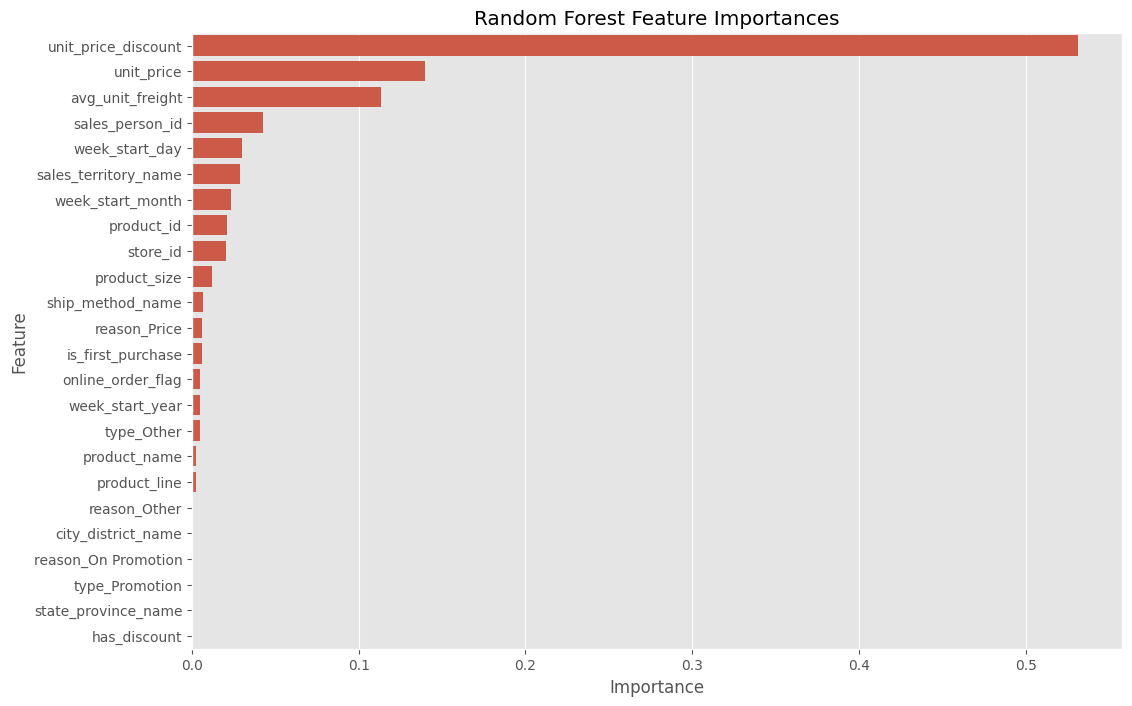

                 Feature    Importance
8    unit_price_discount  5.312696e-01
7             unit_price  1.398227e-01
9       avg_unit_freight  1.131879e-01
12       sales_person_id  4.228411e-02
22        week_start_day  2.998507e-02
3   sales_territory_name  2.875721e-02
21      week_start_month  2.344680e-02
0             product_id  2.105613e-02
6               store_id  2.054688e-02
23          product_size  1.218093e-02
11      ship_method_name  6.305400e-03
15          reason_Price  6.052592e-03
13     is_first_purchase  6.051382e-03
10     online_order_flag  4.944214e-03
20       week_start_year  4.885420e-03
18            type_Other  4.820854e-03
1           product_name  2.275173e-03
2           product_line  2.105824e-03
16          reason_Other  1.058003e-05
4     city_district_name  1.042497e-05
17   reason_On Promotion  3.875740e-07
19        type_Promotion  2.925261e-07
5    state_province_name  1.317768e-07
14          has_discount  0.000000e+00


In [52]:
# Encode categorical columns using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    gloves_df[col] = le.fit_transform(gloves_df[col].astype(str))

# Define features (X) and target (y)
X = gloves_df.drop(columns=['total_products_sold'])  # Features
y = gloves_df['total_products_sold']  # Target variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Random Forest Feature Importances')
plt.show()

# Display sorted feature importances
print(feature_importances)


### Selected Variables

1. **`unit_price_discount`**: A key factor driving sales, with a strong positive influence, indicating how discounts on unit prices affect total sales.
2. **`unit_price`**: Impacts sales, with variations in unit prices affecting overall performance, typically showing a negative correlation.
3. **`sales_person_id`**: Identifies the sales personnel involved, moderately impacting sales outcomes depending on the efficiency of the sales process.
4. **`week_start_day`**: The day of the week when sales start, which can have an impact on consumer behavior and sales patterns.
5. **`sales_territory_name`**: Indicates the region in which the sale occurred, as different territories can exhibit different sales trends.
6. **`week_start_month`**: The month in which sales start, influencing seasonal trends in purchasing behavior.
7. **`store_id`**: Represents the store location, which can affect local sales dynamics based on geographic factors.
8. **`product_id`**: Refers to the specific product sold, influencing sales based on product popularity or demand.
9. **`product_size`**: Product size may affect purchasing decisions, as size variations can impact customer preferences.
10. **`ship_method_name`**: The shipping method selected, which can strongly influence sales by affecting delivery times and customer satisfaction.
11. **`is_first_purchase`**: Whether it’s a new customer’s first purchase, which can have a noticeable impact on sales growth.
12. **`reason_Price`**: Price-related factors influencing sales, showing a significant correlation with purchasing decisions.
13. **`online_order_flag`**: Whether the sale was made online, as e-commerce dynamics can differ from in-store sales.
14. **`type_Other`**: Captures other types of sales behaviors that may not fall into standard categories but still affect overall sales.
15. **`week_start_year`**: The year when sales started, which can help identify long-term trends or changes in sales patterns.


In [53]:
# Select the important variables from the dataset
selected_columns = ['unit_price_discount', 'unit_price', 'sales_person_id',
                    'week_start_day', 'sales_territory_name', 'week_start_month', 'store_id', 
                    'product_id', 'product_size', 'ship_method_name', 'is_first_purchase', 
                    'reason_Price', 'online_order_flag', 'type_Other', 'week_start_year', 'total_products_sold']

# Subset the DataFrame for the selected variables
df_selected = gloves_df[selected_columns]

df_selected


,unit_price_discount,unit_price,sales_person_id,week_start_day,sales_territory_name,week_start_month,store_id,product_id,product_size,ship_method_name,is_first_purchase,reason_Price,online_order_flag,type_Other,week_start_year,total_products_sold
0,0.0,24.490,0,23,0,9,0,0,2,1,1,1,1,1,2013,1
1,0.0,24.490,0,6,0,1,0,0,2,1,1,1,1,1,2014,1
2,0.0,24.490,0,3,0,3,0,0,2,1,1,1,1,1,2014,1
3,0.0,24.490,0,17,0,3,0,0,2,1,1,1,1,1,2014,1
4,0.0,24.490,0,2,0,9,0,0,2,1,1,1,1,1,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,0.0,22.794,9,30,9,7,0,5,0,0,1,0,0,0,2012,10
3136,0.0,22.794,9,31,9,12,0,5,0,0,0,0,0,0,2012,6
3137,0.0,22.794,9,29,9,10,0,5,0,0,0,0,0,0,2012,15
3138,0.0,22.794,14,25,9,6,0,5,0,0,1,0,0,0,2012,8


## Exploratory Data Analysis

### Descriptive Statistics

- **unit_price_discount**: Mean of 0.0028, max of 0.15, showing most products sold with minimal discounts.
- **unit_price**: Average of 20.84, ranging from 12.95 to 24.69, indicating a broad price distribution.
- **week_start_day**: Average start day is 22nd, with sales distributed across the month.
- **week_start_month**: Mean of 6.43, with sales spread evenly throughout the year.
- **week_start_year**: Sales mainly occur around 2013, ranging from 2012 to 2014.
- **total_products_sold**: Mean of 4.14, with a max of 44, showing high variability in sales quantities.


In [54]:
# Define a color palette for the charts
color_palette = plt.get_cmap('Blues')

# Set a style for the plots
plt.style.use('ggplot')

# Correct numerical variables, excluding ID-like fields and categorical fields
numerical_vars = ['unit_price_discount', 'unit_price', 'week_start_day', 'week_start_month', 'week_start_year', 'total_products_sold']

# 1. Descriptive Statistics for Numerical Variables
df_selected[numerical_vars].describe()


,unit_price_discount,unit_price,week_start_day,week_start_month,week_start_year,total_products_sold
count,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.0
mean,0.002761,20.842272,21.945541,6.432166,2013.045860,4.143949
std,0.012340,4.449968,8.421662,3.307851,0.715593,5.187007
min,0.000000,12.951500,1.000000,1.000000,2012.000000,1.0
25%,0.000000,14.694000,17.000000,4.000000,2013.000000,1.0
50%,0.000000,22.794000,25.000000,6.000000,2013.000000,1.0
75%,0.000000,24.490000,28.000000,9.000000,2014.000000,5.0
max,0.150000,24.693500,31.000000,12.000000,2014.000000,44.0


### Distribution Plots for Numerical Variables

- **unit_price_discount**: Highly skewed towards 0, indicating that most products have minimal or no discount applied, with a few receiving higher discounts.

- **unit_price**: The distribution shows two distinct price levels, with most products clustered around 14 and 24, indicating product pricing tends to fall into two major categories.

- **week_start_day**: Displays a relatively uniform distribution throughout the month, with a noticeable increase towards the end of the month, suggesting higher sales during the last week.

- **week_start_month**: The distribution across months is fairly even, indicating that sales occur consistently throughout the year without major seasonal spikes.

- **week_start_year**: The distribution across years is fairly even.

- **total_products_sold**: Strongly right-skewed, with most products selling in low quantities, while only a few have significantly higher sales, indicating a small group of high-demand products.


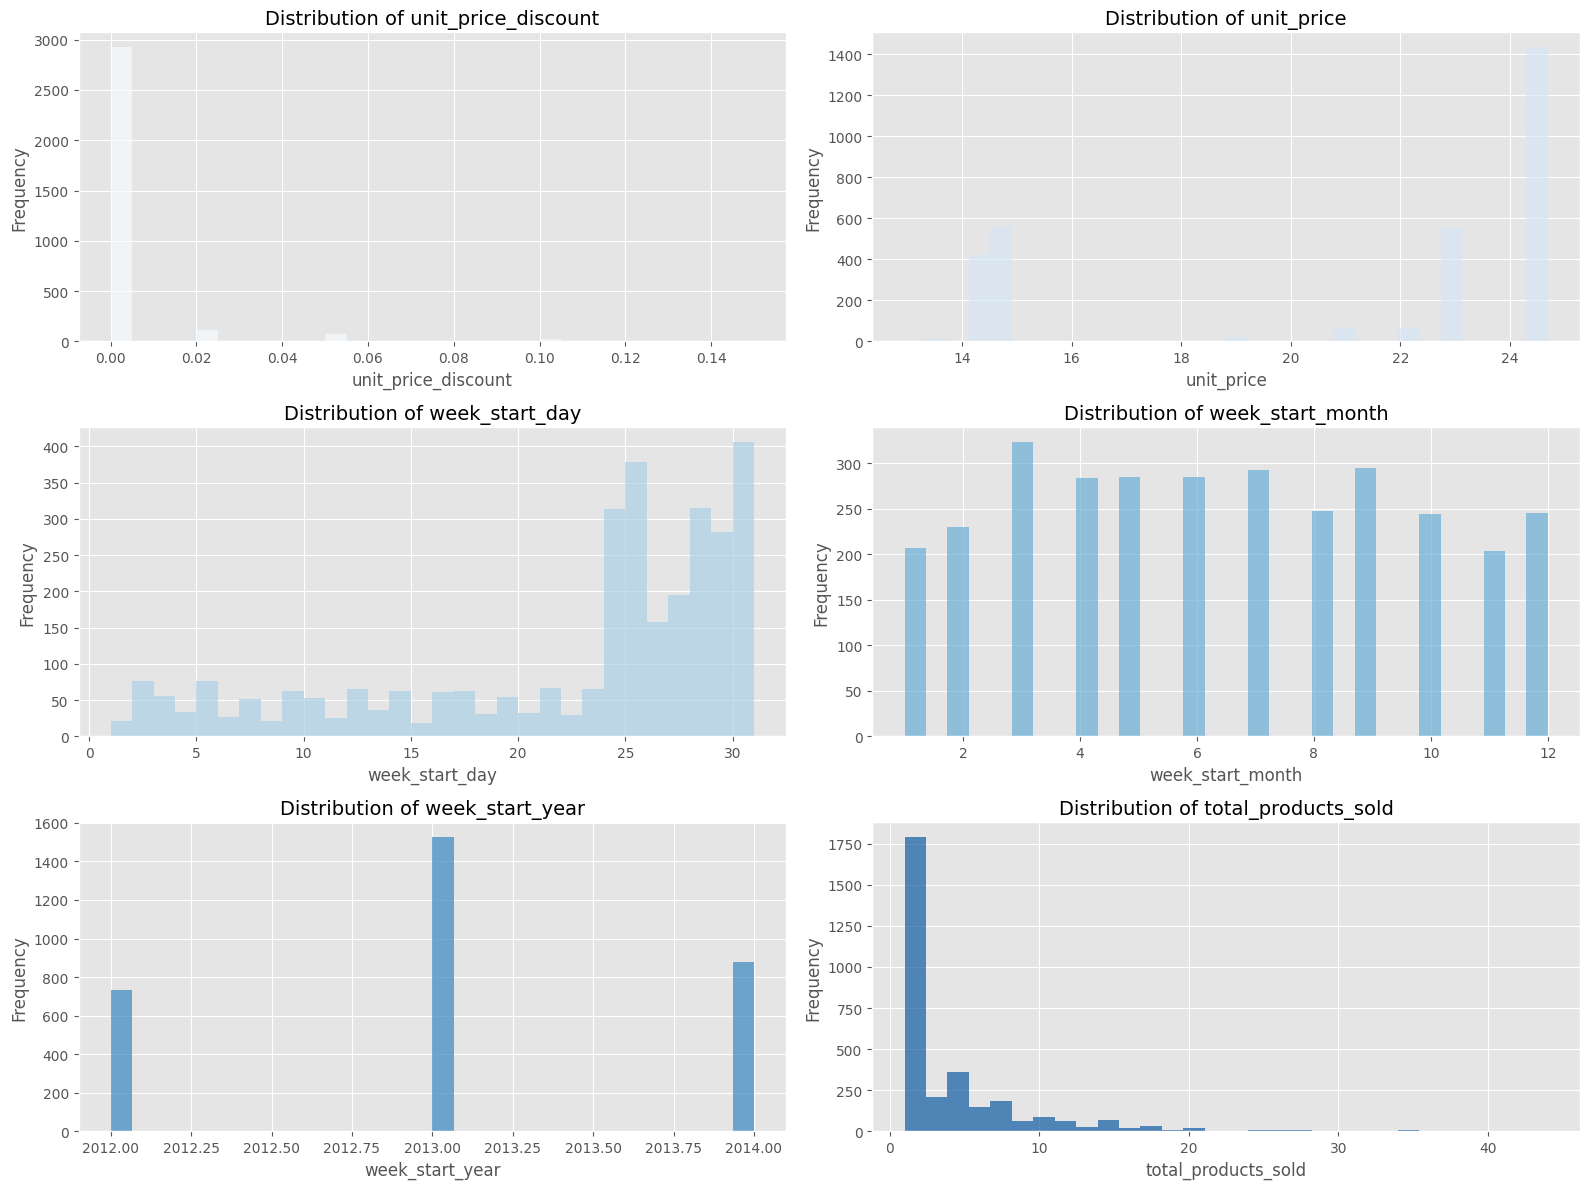

In [55]:
# Plot the distribution of the numerical variables with a clean style
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    axes[i].hist(df_selected[var], bins=30, color=color_palette(i/len(numerical_vars)), alpha=0.7)
    axes[i].set_title(f'Distribution of {var}', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


### Correlation Heatmap for Numerical Variables

- **High Positive Correlations**:
  - `unit_price_discount` and `total_products_sold` (0.71): Products sold with discounts have a strong positive relationship with total sales, reinforcing their importance in sales volume.
  - `week_start_day` and `total_products_sold` (0.38): Sales tend to increase towards certain days of the month.

- **Negative Correlations**:
  - `unit_price` and `total_products_sold` (-0.33): Higher unit prices correlate negatively with total products sold, indicating that higher-priced products tend to sell less.
  - `week_start_year` and `total_products_sold` (-0.38): The year has a negative correlation with the sales

- **Weak Correlations**:
  - `week_start_month` also shows weak or no correlation with other variables, suggesting limited influence of the time of year on product sales.


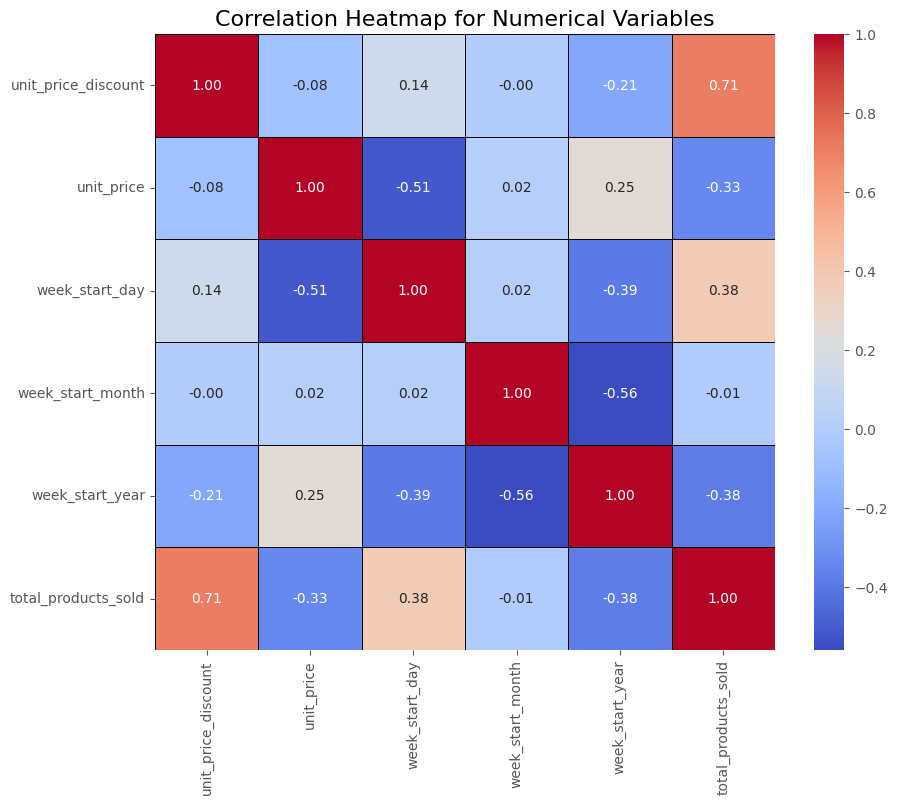

In [56]:
# Display a heatmap to see the relationships between the numerical variables
plt.figure(figsize=(10, 8))
corr_matrix = df_selected[numerical_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap for Numerical Variables', fontsize=16)
plt.show()


### Pair Plots for Numerical Variables

- **Clustered Data**: Most variables exhibit clustering at low values, especially for `unit_price_discount`, `avg_unit_freight`, and `total_products_sold`. This suggests that the majority of observations fall within a narrow range, with a few outliers present.

- **No Clear Linear Relationships**: The pair plots do not show any strong linear relationships between the numerical variables, though there are noticeable patterns. For example, `unit_price_discount` and `total_products_sold` show a concentration of values near zero.

- **Outliers**: Significant outliers are visible, particularly in `total_products_sold`. These outliers could affect the overall analysis and may need to be handled accordingly.

- **Non-linear Distributions**: Many of the scatter plots display non-linear distributions, where most data points cluster near low values but spread out at higher values.


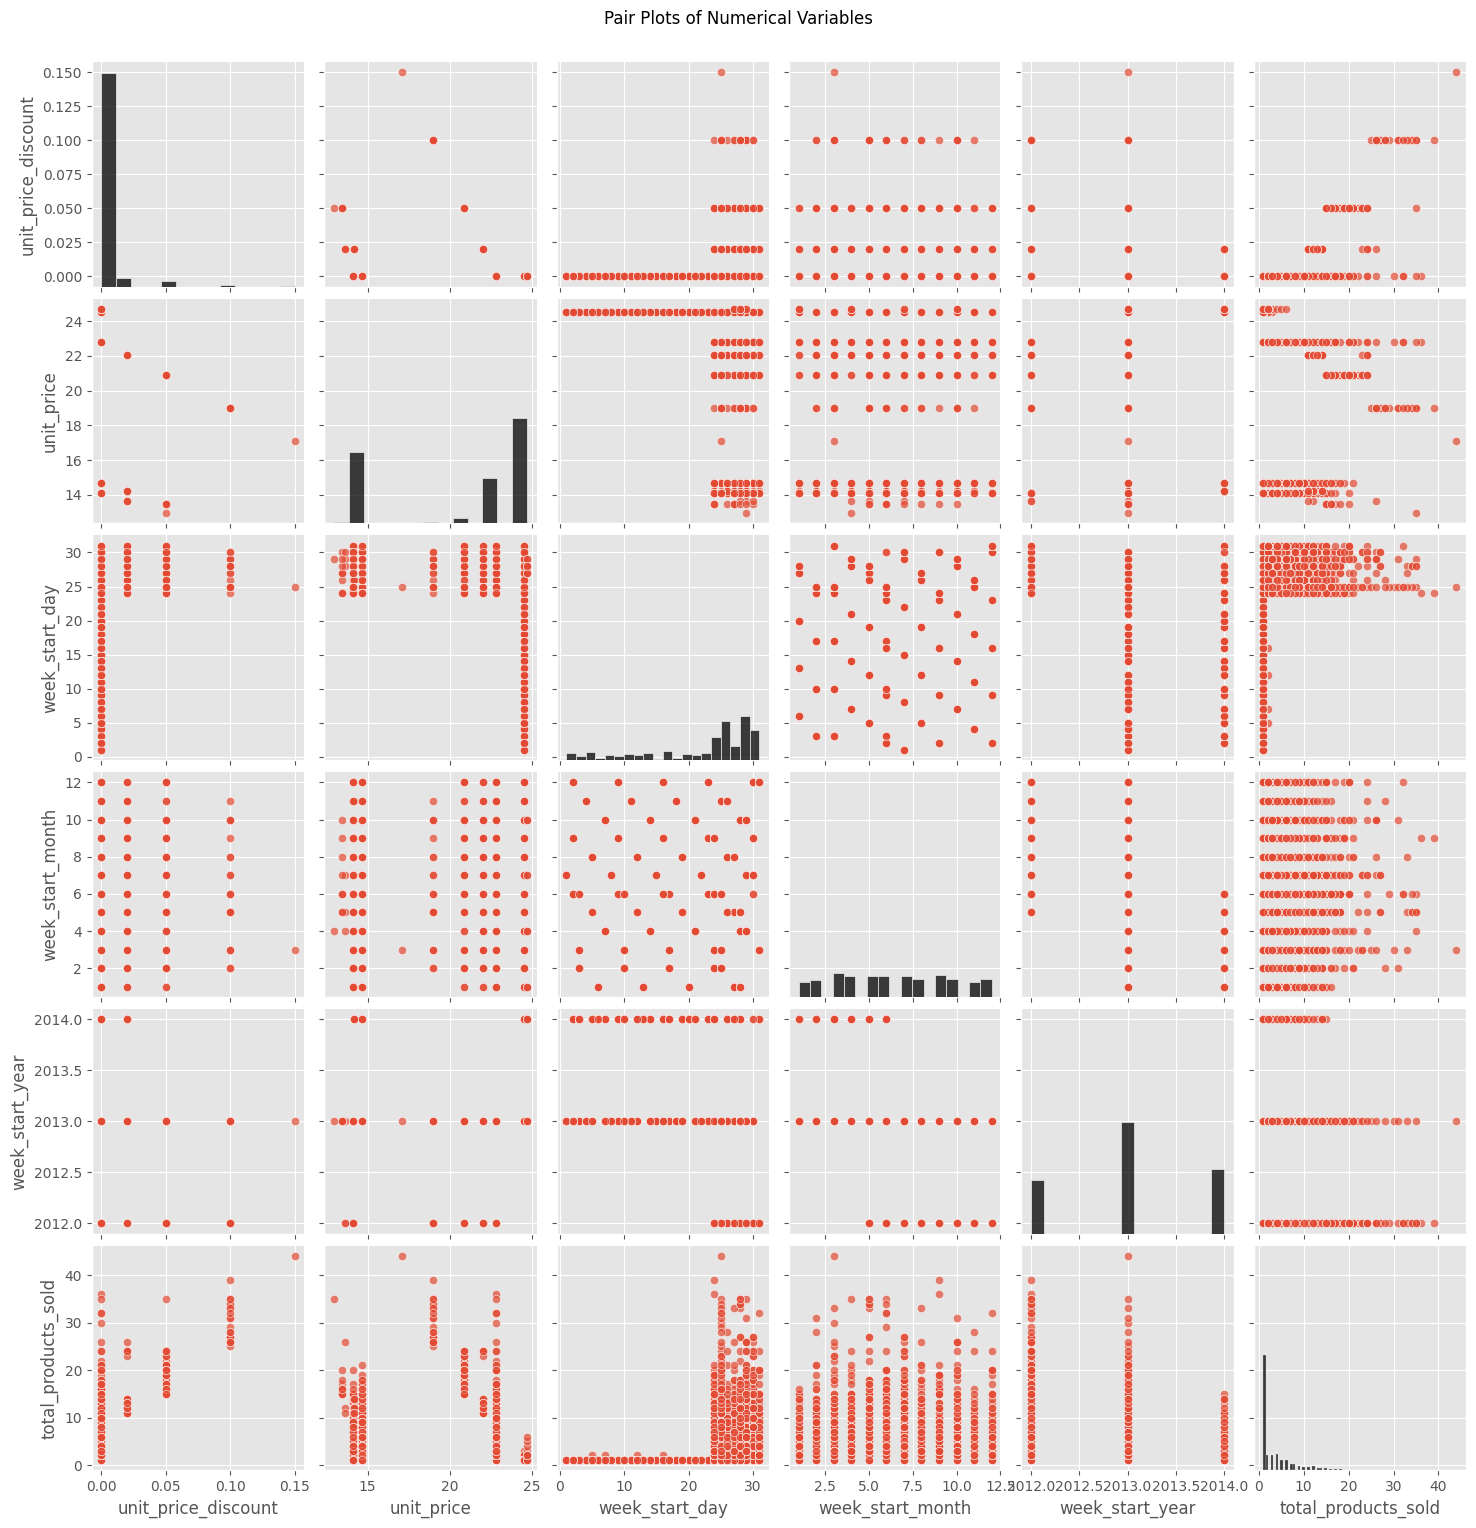

In [57]:
# Pair plots for exploring relationships between numerical variables
sns.pairplot(df_selected[numerical_vars], plot_kws={'alpha':0.7}, diag_kws={'color':'black'})
plt.suptitle('Pair Plots of Numerical Variables', y=1.02)
plt.show()


### Bar Plots for Categorical Variables

- **sales_person_id**: Sales person "0" has the highest frequency, indicating that many sales do not have a salesperson attached to the purchase. Following this, IDs 4, 3, 16, and 2 have the next highest sales, suggesting they are the top-performing salespeople.

- **sales_territory_name**: Territory "8" has the highest sales, followed by territories 1, 6, 0, and 9, indicating that these regions contribute the most to sales.

- **store_id**: The majority of orders do not have a store ID registered (store_id = 0), showing that most sales may occur through other channels or have missing store data.

- **product_id**: Products "1," "0," and "2" are the most sold, indicating a concentration of sales in these top-selling products.

- **product_size**: Product sizes are evenly distributed, indicating that no particular size dominates sales.

- **ship_method_name**: Shipping methods are well balanced, with no significant preference for one method over another.

- **is_first_purchase**: Most customers are new (is_first_purchase = 1), suggesting that the business is successfully acquiring new customers, though it might also point to a potential issue with customer retention.

- **reason_Price**: Reasons for purchases are evenly split between price-related and other factors, indicating a balanced influence of price on purchase decisions.

- **online_order_flag**: Online and offline orders are nearly equally distributed, showing the importance of both channels in driving sales.

- **type_Other**: Purchases driven by "other" factors are also well distributed, indicating a variety of motivations for customer purchases.


In [58]:
df_selected.columns

Index(['unit_price_discount', 'unit_price', 'sales_person_id',
       'week_start_day', 'sales_territory_name', 'week_start_month',
       'store_id', 'product_id', 'product_size', 'ship_method_name',
       'is_first_purchase', 'reason_Price', 'online_order_flag', 'type_Other',
       'week_start_year', 'total_products_sold'],
      dtype='object')

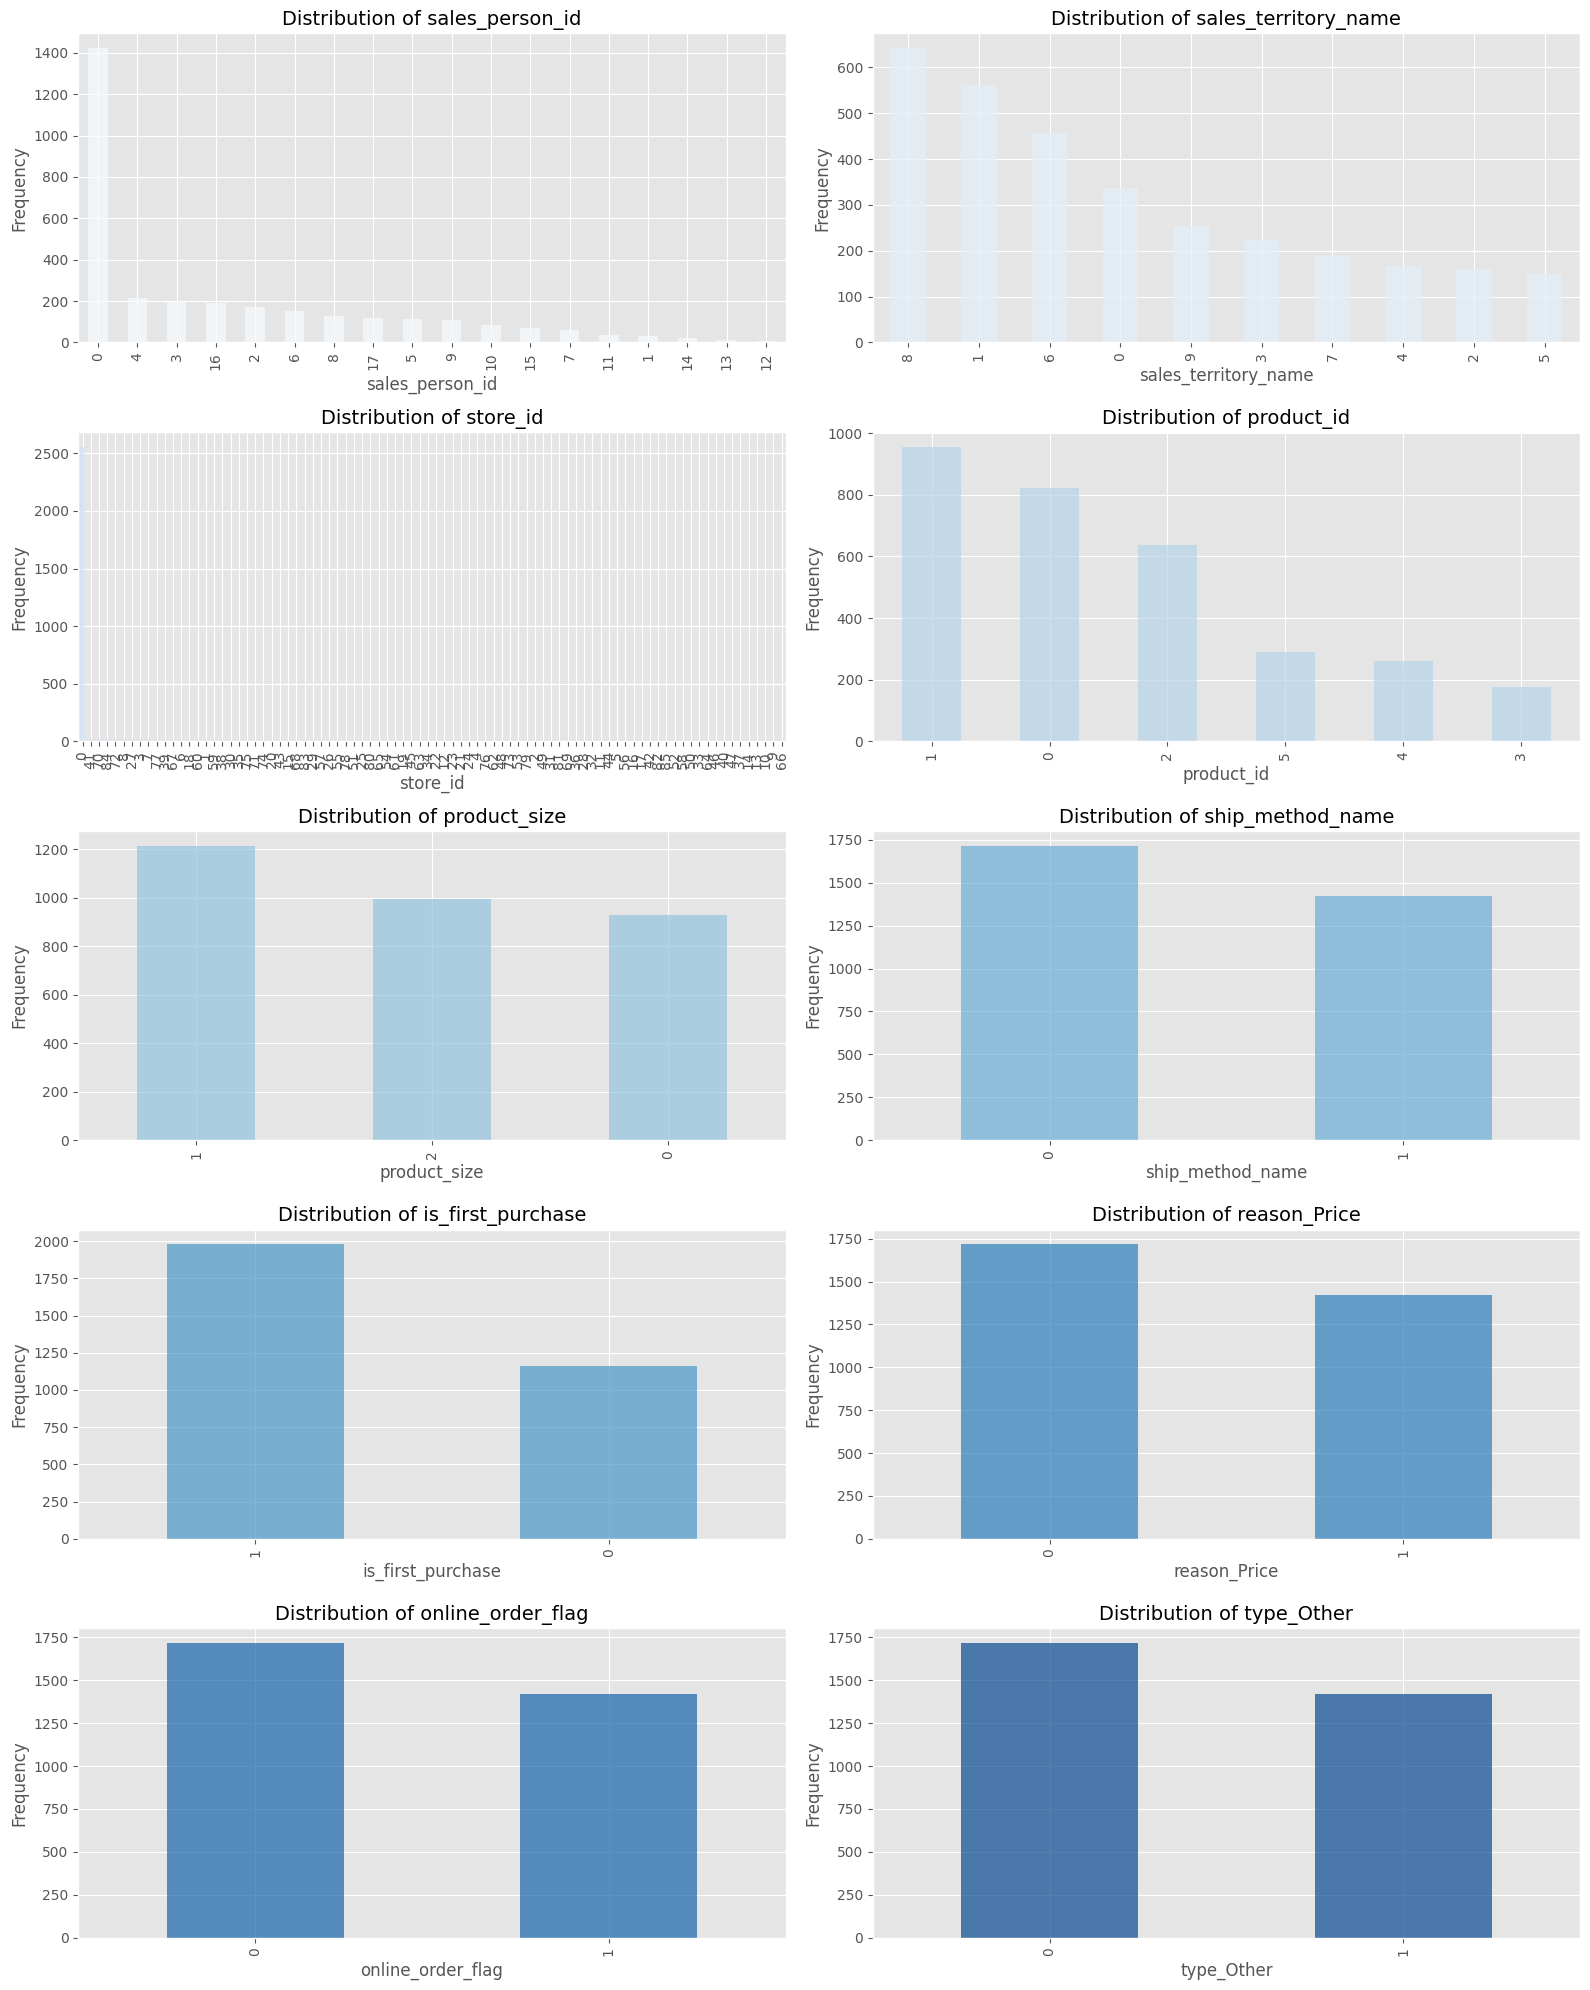

In [59]:
# Visualize the distribution of the categorical variables
categorical_vars = ['sales_person_id', 'sales_territory_name',
                    'store_id', 'product_id', 'product_size', 'ship_method_name',
                    'is_first_purchase', 'reason_Price', 'online_order_flag', 'type_Other',]

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    df_selected[var].value_counts().plot(kind='bar', ax=axes[i], color=color_palette(i/len(categorical_vars)), alpha=0.7)
    axes[i].set_title(f'Distribution of {var}', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## Train-test split
- Splitting data in train and test datasets

In [60]:
# Defining the features (X) and the target variable (y)
X = df_selected.drop(columns=['total_products_sold'])  # Features
y = df_selected['total_products_sold']  # Target

# Splitting the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Checking the sizes of the training and testing sets
print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')


Training set size: (2198, 15)
Testing set size: (942, 15)


## Selecting models and training

### Random Forest Regressor first implementation
- **Handles Categorical Data**: Suitable for features like `ship_method_name`, and `is_first_purchase`.
- **Feature Importance**: Can highlight key drivers of `total_products_sold` such as `unit_price_discount` or `product_size`.
- **Non-linear Interactions**: Captures complex relationships between features, important for dynamic sales data.

In [61]:
# Function to train the RandomForest model
def train_random_forest(X_train, y_train):
    # Creating the RandomForest model
    rf_model = RandomForestRegressor(random_state=42)
    
    # Training the model
    rf_model.fit(X_train, y_train)
    
    return rf_model

# Training RandomForest
rf_model = train_random_forest(X_train, y_train)


### XGBoost Regressor first implementation
- **High Accuracy**: Optimized for performance on structured data, which fits well with our cleaned and engineered dataset.
- **Handles Missing Data**: Efficient for any missing values fields.
- **Regularization**: Reduces overfitting in high-dimensional data like multiple sales features (`unit_price`, `online_order_flag`).

In [62]:
# Function to train the XGBoost model
def train_xgboost(X_train, y_train):
    # Creating the XGBoost model
    xgb_model = xgb.XGBRegressor(random_state=42)
    
    # Training the model
    xgb_model.fit(X_train, y_train)
    
    return xgb_model

# Training XGBoost
xgb_model = train_xgboost(X_train, y_train)


## Models evaluation
- Evaluating models using Mean Absolute Error (MAE), Mean Squared Error (MSE) and R-squared (R²) metrics

In [63]:
# Function to evaluate a model's performance
def evaluate_model(model, X_test, y_test):
    # Making predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculating metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Printing the evaluation results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")

# Evaluating RandomForest
print("RandomForest Evaluation:")
evaluate_model(rf_model, X_test, y_test)

# Evaluating XGBoost
print("\nXGBoost Evaluation:")
evaluate_model(xgb_model, X_test, y_test)


RandomForest Evaluation:
Mean Absolute Error (MAE): 1.4075893741785461
Mean Squared Error (MSE): 6.202313117260882
R-squared (R²): 0.7289197300961294

XGBoost Evaluation:
Mean Absolute Error (MAE): 1.4923006981105056
Mean Squared Error (MSE): 6.760916144622869
R-squared (R²): 0.7045052647590637


## Hyperparameter tuning
- After the first evaluation, we try to find better parameters for both models to tune our results

### Random Forest Hyperparameter Tuning

In [64]:
# Defining the hyperparameters to tune for RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setting up the GridSearchCV for RandomForest
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=rf_param_grid,
                              cv=3, n_jobs=-1, verbose=2)

# Running the GridSearchCV to find the best parameters
rf_grid_search.fit(X_train, y_train)

# Best hyperparameters for RandomForest
print("Best RandomForest hyperparameters:", rf_grid_search.best_params_)

# Using the best model from RandomForest tuning
best_rf_model = rf_grid_search.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; tot

### XGBoost Hyperparameter Tuning

In [65]:
# Defining the hyperparameters to tune for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.2]
}

# Setting up the GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42),
                               param_grid=xgb_param_grid,
                               cv=3, n_jobs=-1, verbose=2)

# Running the GridSearchCV to find the best parameters
xgb_grid_search.fit(X_train, y_train)

# Best hyperparameters for XGBoost
print("Best XGBoost hyperparameters:", xgb_grid_search.best_params_)

# Using the best model from XGBoost tuning
best_xgb_model = xgb_grid_search.best_estimator_


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_dept

## Models Evaluation After Hyperparameter Tuning

### Comparison of RandomForest and XGBoost Before and After Hyperparameter Tuning:

#### RandomForest Evaluation (Before Tuning):
- **Mean Absolute Error (MAE)**: 1.4076
- **Mean Squared Error (MSE)**: 6.2023
- **R-squared (R²)**: 0.7289

#### XGBoost Evaluation (Before Tuning):
- **Mean Absolute Error (MAE)**: 1.4923
- **Mean Squared Error (MSE)**: 6.7609
- **R-squared (R²)**: 0.7045

---

#### Tuned RandomForest Evaluation:
- **Mean Absolute Error (MAE)**: 1.3779
- **Mean Squared Error (MSE)**: 5.9323
- **R-squared (R²)**: 0.7407

#### Tuned XGBoost Evaluation:
- **Mean Absolute Error (MAE)**: 1.3989
- **Mean Squared Error (MSE)**: 5.7874
- **R-squared (R²)**: 0.7471

---

### Model Comparison:

- After tuning, **XGBoost** shows improvement, and it slightly outperforms **RandomForest** in terms of **Mean Squared Error (MSE)** and **R-squared (R²)**.
- The **Tuned RandomForest** has a **MAE** of 1.3779 and an **R-squared** of 0.7407, while the **Tuned XGBoost** has a **MAE** of 1.3989 and a higher **R-squared** of 0.7471, making XGBoost the better model in terms of R-squared.

### Best Model:

Based on the evaluation metrics, the **Tuned XGBoost** model is the best-performing model due to its higher **R-squared** value (0.7471) and lower **Mean Squared Error (MSE)**. However, **RandomForest** still achieves a slightly lower **Mean Absolute Error (MAE)**.


In [66]:
# Evaluating the tuned RandomForest model
print("Tuned RandomForest Evaluation:")
evaluate_model(best_rf_model, X_test, y_test)

# Evaluating the tuned XGBoost model
print("\nTuned XGBoost Evaluation:")
evaluate_model(best_xgb_model, X_test, y_test)


Tuned RandomForest Evaluation:
Mean Absolute Error (MAE): 1.3778988833367085
Mean Squared Error (MSE): 5.9322563546820755
R-squared (R²): 0.7407229168597089

Tuned XGBoost Evaluation:
Mean Absolute Error (MAE): 1.398850313290922
Mean Squared Error (MSE): 5.787441654678388
R-squared (R²): 0.7470522522926331


## Training selected model with the complete dataset

In [67]:
# Defining features (X) and target (y) from the full dataset
X_full = df_selected.drop(columns=['total_products_sold'])
y_full = df_selected['total_products_sold']

# Training the XGBoost model with the full dataset using the best hyperparameters
final_xgb_model = xgb.XGBRegressor(
    n_estimators=best_xgb_model.n_estimators,
    learning_rate=best_xgb_model.learning_rate,
    max_depth=best_xgb_model.max_depth,
    subsample=best_xgb_model.subsample,
    colsample_bytree=best_xgb_model.colsample_bytree,
    gamma=best_xgb_model.gamma,
    random_state=42
)

# Fitting the final model to the full dataset
final_xgb_model.fit(X_full, y_full)

# The final model is now trained with all available data
print("Final XGBoost model trained with the full dataset.")

Final XGBoost model trained with the full dataset.


## Predicting sales for next 3 months (12 weeks)

### Selecting most recent sales date
- 3 months will start from this date, and predicted by week starting on sundays

In [68]:
# Filtering gloves sales only
gloves_data = agg_sales_by_product[agg_sales_by_product['product_subcategory_name'].str.contains('Gloves', na=False)]

# Getting most recent sales date
most_recent_date = gloves_data['week_start_date'].max()
print(f"Most recent date: {most_recent_date}")

Most recent date: 2014-06-30 00:00:00


### Generating week start dates for next 3 months 
- Starting on sunday

In [69]:
# Generate next 12 weeks date staring by sunday
next_12_weeks = pd.date_range(start=most_recent_date + timedelta(days=7), periods=12, freq='W-SUN')

print(next_12_weeks)

DatetimeIndex(['2014-07-13', '2014-07-20', '2014-07-27', '2014-08-03',
               '2014-08-10', '2014-08-17', '2014-08-24', '2014-08-31',
               '2014-09-07', '2014-09-14', '2014-09-21', '2014-09-28'],
              dtype='datetime64[ns]', freq='W-SUN')


### Creating prediction dataset
- Including all column values for the next 12 weeks
- This will generate prediction for all varying parameters

In [70]:
# Assuming 'next_12_weeks' is a pandas date range, we calculate week_start_day, month, and year once
df_weeks = pd.DataFrame({
    'week_start': next_12_weeks,
    'week_start_day': next_12_weeks.day,
    'week_start_month': next_12_weeks.month,
    'week_start_year': next_12_weeks.year
})

# Only select the unique values from the essential columns
columns_to_select = ['unit_price_discount', 'unit_price', 'sales_person_id', 'sales_territory_name', 
                     'store_id', 'product_id', 'product_size', 'ship_method_name', 'is_first_purchase', 
                     'reason_Price', 'online_order_flag', 'type_Other']

# Reduce the number of unique values for better performance
df_selected = df_selected[columns_to_select].drop_duplicates()

# Now we expand the df_selected by exploding with the 12-week data
df_selected['key'] = 1  # Create a key to join with weeks data
df_weeks['key'] = 1

# Use cross-join to combine the dataset with weeks
prediction_df = pd.merge(df_selected, df_weeks, on='key').drop('key', axis=1)

# Select only the final columns you want
prediction_df = prediction_df[['unit_price_discount', 'unit_price', 'sales_person_id', 
                               'week_start_day', 'week_start_year', 'week_start_month',
                               'sales_territory_name', 'store_id', 'product_id', 
                               'product_size', 'ship_method_name', 'is_first_purchase', 
                               'reason_Price', 'online_order_flag', 'type_Other']]

# Show the final dataframe
prediction_df


,unit_price_discount,unit_price,sales_person_id,week_start_day,week_start_year,week_start_month,sales_territory_name,store_id,product_id,product_size,ship_method_name,is_first_purchase,reason_Price,online_order_flag,type_Other
0,0.0,24.490,0,13,2014,7,0,0,0,2,1,1,1,1,1
1,0.0,24.490,0,20,2014,7,0,0,0,2,1,1,1,1,1
2,0.0,24.490,0,27,2014,7,0,0,0,2,1,1,1,1,1
3,0.0,24.490,0,3,2014,8,0,0,0,2,1,1,1,1,1
4,0.0,24.490,0,10,2014,8,0,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10711,0.0,22.794,14,31,2014,8,9,0,5,0,0,1,0,0,0
10712,0.0,22.794,14,7,2014,9,9,0,5,0,0,1,0,0,0
10713,0.0,22.794,14,14,2014,9,9,0,5,0,0,1,0,0,0
10714,0.0,22.794,14,21,2014,9,9,0,5,0,0,1,0,0,0


### Predicting sales data
- After generating the prediction dataframe, we predict all the values for the next 3 months (12 weeks)

In [71]:
# Define the expected feature names from the trained model
model_features = [
    'unit_price_discount', 'unit_price', 'sales_person_id', 'week_start_day',
    'sales_territory_name', 'week_start_month', 'store_id', 'product_id',
    'product_size', 'ship_method_name', 'is_first_purchase', 'reason_Price',
    'online_order_flag', 'type_Other', 'week_start_year'
]

# Reorder the columns in prediction_df to match the model's feature order
prediction_df = prediction_df[model_features]

# Make predictions with the trained model
future_predictions = final_xgb_model.predict(prediction_df)

# Adding predictions to df
prediction_df['predicted_sales'] = future_predictions

prediction_df

,unit_price_discount,unit_price,sales_person_id,week_start_day,sales_territory_name,week_start_month,store_id,product_id,product_size,ship_method_name,is_first_purchase,reason_Price,online_order_flag,type_Other,week_start_year,predicted_sales
0,0.0,24.490,0,13,0,7,0,0,2,1,1,1,1,1,2014,1.110132
1,0.0,24.490,0,20,0,7,0,0,2,1,1,1,1,1,2014,1.110132
2,0.0,24.490,0,27,0,7,0,0,2,1,1,1,1,1,2014,0.751404
3,0.0,24.490,0,3,0,8,0,0,2,1,1,1,1,1,2014,0.904146
4,0.0,24.490,0,10,0,8,0,0,2,1,1,1,1,1,2014,0.904146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10711,0.0,22.794,14,31,9,8,0,5,0,0,1,0,0,0,2014,3.419894
10712,0.0,22.794,14,7,9,9,0,5,0,0,1,0,0,0,2014,4.483281
10713,0.0,22.794,14,14,9,9,0,5,0,0,1,0,0,0,2014,4.483281
10714,0.0,22.794,14,21,9,9,0,5,0,0,1,0,0,0,2014,4.483281


## Quantity of zipers demanded
- The quantity of zipers demanded is the sum of all predicted sales times 2

In [72]:
num_zipers = np.round(prediction_df['predicted_sales'].sum() * 2)
print('The number of required zipers is approximately {}'.format(num_zipers))

The number of required zipers is approximately 142973.0
